# Corey Nelson
## Homework 2: Due 2017-10-18 (Wednesday)

* Implement an explicit Runge-Kutta integrator that takes an initial time step $h_0$ and an error tolerance $\epsilon$.
* You can use the Bogacki-Shampine method or any other method with an embedded error estimate.
* A step should be rejected if the local truncation error exceeds the tolerance.
* Test your method on the nonlinear equation
$$ \begin{bmatrix} \dot u_0 \\ \dot u_1 \end{bmatrix} = \begin{bmatrix} u_1 \\ k (1-u_0^2) u_1 - u_0 \end{bmatrix} $$
for $k=2$, $k=5$, and $k=20$.
* Make a work-precision diagram for your adaptive method and for constant step sizes.
* State your conclusions or ideas (in a README, or Jupyter notebook) about appropriate (efficient, accurate, reliable) methods for this type of problem.

First we define our RK solver and our adaptive butcher table. We will use the Bogacki–Shampine method, and the RK-Fehlberg method (for kicks!) for our adaptivity. The solver is adapted from the one used in class.

In [111]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')


def rk_butcher_bs3():
    A = numpy.array([[0, 0, 0, 0],
                     [1/2, 0, 0, 0],
                     [0, 3/4, 0, 0],
                     [2/9, 1/3, 4/9, 0]])
    b = numpy.array([[2/9, 1/3, 4/9, 0],
                     [7/24, 1/4, 1/3, 1/8]])
    p = 3 #modify butcher block object to return convergence order
    return A, b, p

def rk_buthcher_rkf(): #RK-Fehlberg, https://en.wikipedia.org/wiki/Runge–Kutta–Fehlberg_method
    A = numpy.array([[0,        0,         0,          0,         0,      0],
                     [1/4,      0,         0,          0,         0,      0],
                     [3/32,     9/32,      0,          0,         0,      0],
                     [1932/2197,-7200/2197,7296/2197,  0,         0,      0],
                     [439/216,  -8,        3680/513,   -845/4104, 0,      0],
                     [-8/27,    2,         -3544/2565, 1859/4104, -11/40, 0]])
    b = numpy.array([[16/135,0,6656/12825,28561/56430,-9/50,2/55],
                     [25/216,0,1408/2565, 2197/4104,  -1/5, 0]]) 
    #that took awhile to type out even copy/pasting from wikipedia...
    p = 5
    return A, b, p

def ode_rkexplicit_adaptive(f, u0, butcher=None, tol = 1e-8, tfinal=1, h=.1):
    if butcher is None:
        A, b, p = rk_butcher_bs3()
    else:
        A, b, p = butcher
    c = numpy.sum(A, axis=1) #butcher table C column
    s = len(c)    #number of steps in the RK method
    u = u0.copy() #intitial condition
    t = 0 #intitial time
    hist = [(t,u0)] #history of solution
    h_hist = [(t,h)] #history of time steps
    e_hist = [] #history of error, will append every steps
    redo_hist = [] #history of redone steps
    redoStep = 0 #flag to redo the timestep if its error is too high
    h_given = h
    while t < tfinal: #loop over time
        if tfinal - t < 1.01*h: #if the current time step is real close to finishing off the sim. just finish it off
            h = tfinal - t
            tnext = tfinal
        elif  not redoStep:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        eloc = max(h * fY.dot(b[0,:]-b[1,:])) #take the max error of the 2 solutions
        e_hist.append(eloc)
        if eloc > tol:
            h = 0.9 * h * (tol / eloc)**(1/p)
            redoStep = 1;
        else:
            u += h * fY.dot(b[0,:])
            t = tnext
            redoStep = 0
            h_hist.append((t, h))
            hist.append((t, u.copy()))
            #h = h_given #this timestep worked, so try to use the given time step in the next step
        redo_hist.append(redoStep)
        
    return hist, h_hist, e_hist, redo_hist

def ode_rkexplicit(f, u0, butcher=None, tfinal=1, h=.1):
    if butcher is None:
        A, b,p = rk_butcher_4()
    else:
        A, b,p = butcher
    b = b[0,:]
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        u += h * fY.dot(b)
        t = tnext
        hist.append((t, u.copy()))
    return hist

Next we will define our problem parameters here:

0.00212511893329
0.000838474741943
1.99317747374e-05


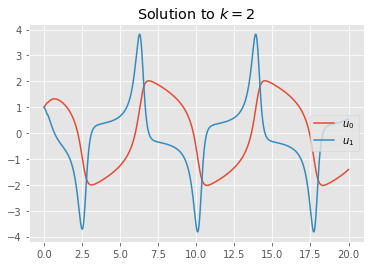

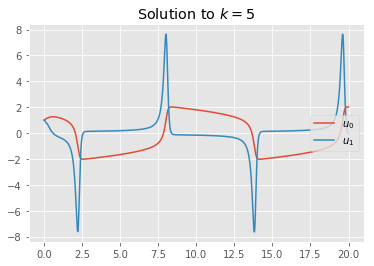

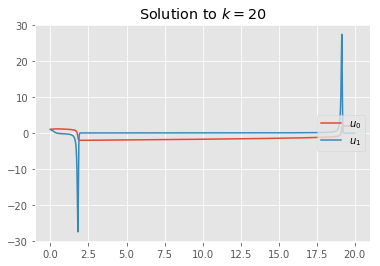

In [115]:
class ftestNonlinear:
    def __init__(self, k=5):
        self.k = k
    def __repr__(self):
        return 'fcos(k={:d})'.format(self.k)
    def f(self,t, u):
        return [ u[1], self.k*(1-u[0]**2)*u[1]-u[0] ]

tests = [ftestNonlinear(2), ftestNonlinear(5), ftestNonlinear(20)]

u0 = numpy.array([1.0, 1])

for test in tests:
    hist, h_hist, e_hist,redo_hist = ode_rkexplicit_adaptive(test.f, u0, butcher = rk_buthcher_rkf(),tol = 1e-12,h = .05,tfinal = 20)
    times = [t for t,u in hist]
    print(min([h for t,h in h_hist]))
    pyplot.figure()
    pyplot.plot(times, [u[0] for t,u in hist], label = '$u_0$')
    pyplot.plot(times, [u[1] for t,u in hist], label = '$u_1$')
    pyplot.legend(loc='right')
    pyplot.title('Solution to $k = %d$'%test.k)
    


This system exhibits periodic behavior with sharp peaks and long durations of slow change. Ideally, the RK method would adapt and use longer time steps for the slow change periods and short time steps for the spikes. 

Next, we will compare the work done by the adaptive method versus a non-adaptive method

In [120]:
def expm(A):
    """Compute the matrix exponential"""
    L, X = numpy.linalg.eig(A)
    return X.dot(numpy.diag(numpy.exp(L))).dot(numpy.linalg.inv(X))
u0 = numpy.array(0.5)
class linear:
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, u):
        return self.A.dot(u)
    def u(self, t, u0):
        t = numpy.array(t, ndmin=1)
        return [numpy.real(expm(self.A*s).dot(u0)) for s in t]

test = linear(numpy.array([[0, 1],[-1, 0]]))
u0 = numpy.array([.5, 0])
def mms_error_adaptive(h, rk_butcher):
    hist, h_hist, e_hist,redo_hist = ode_rkexplicit_adaptive(test.f, u0, rk_butcher(), tfinal=20, h=h)
    numSteps = len(e_hist)
    times = numpy.array([t for t,u in hist])
    u = numpy.array([u for t,u in hist])
    return numpy.linalg.norm(u - test.u(times,u0), numpy.inf), numSteps

def mms_error(h, rk_butcher):
    hist = ode_rkexplicit(test.f, u0, rk_butcher(), tfinal=20, h=h)
    numSteps = len(hist)
    times = numpy.array([t for t,u in hist])
    u = numpy.array([u for t,u in hist])
    return numpy.linalg.norm(u - test.u(times,u0), numpy.inf), numSteps



hs = numpy.logspace(-2, -.7, 20)
errorAdaptive = []
numStepsAdaptive = []
errorNominal = []
numStepsNominal  = []
for i in range(0,19):
    a,b = mms_error_adaptive(hs[i], rk_butcher_bs3)
    errorAdaptive.append(a)
    numStepsAdaptive.append(b)
    c,d = mms_error(hs[i], rk_butcher_bs3)
    errorNominal.append(c)
    numStepsNominal.append(d)



0.11399031517215868

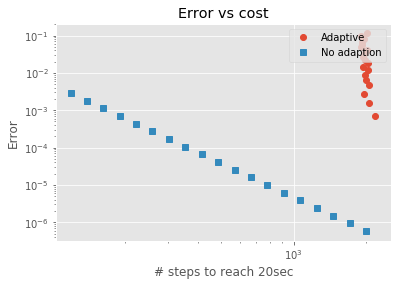

In [121]:
pyplot.figure()
pyplot.loglog(numStepsAdaptive, errorAdaptive, 'o', label='Adaptive')
pyplot.loglog(numStepsNominal, errorNominal, 's', label='No adaption')
pyplot.title('Error vs cost')
pyplot.ylabel('Error')
pyplot.xlabel('# steps to reach 20sec')
pyplot.legend(loc='upper right');
max(errorAdaptive)

To compare the work of the adaptive method versus the non-adaptive method, we can count the number of time steps (discarded or kept) to reach the end of the simulation. We are using the same butcher table for each method, so a single timestep should be roughly the same cost for each method. However, we are throwing out time steps that do not reach the desired error tolerance in the adaptive method, so we must include them in our plot. As seen above, for this simple, smooth problem, we have to do significantly more work with the adaptive method than we do with the non-adaptive method. It seems like we aren't doing super great with the adaptive method. 

However, if we look at the profile of the error over the entire simulation, we see an interesting characteristic:

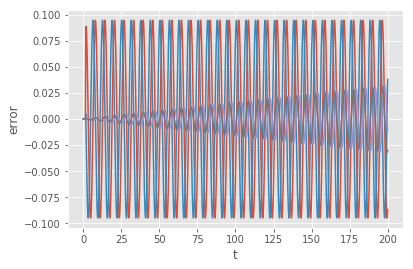

In [136]:
histA, h_hist, e_hist,redo_hist = ode_rkexplicit_adaptive(test.f, u0, rk_butcher_bs3(), tfinal=200, h=h)
timesA = numpy.array([t for t,u in histA])
uA = numpy.array([u for t,u in histA])

histN = ode_rkexplicit(test.f, u0, rk_butcher_bs3(), tfinal=200, h=h)
timesN = numpy.array([t for t,u in histN])
uN = numpy.array([u for t,u in histN])

pyplot.figure()
pyplot.plot(timesA, uA - test.u(timesA,u0), label= 'adaptive error')
pyplot.plot(timesN, uN - test.u(timesN,u0), label= 'non-adaptive error')
pyplot.xlabel('t')
pyplot.ylabel('error')

This plot shows that for the adaptive solver, we have extremely consistant error for a very long simulation time. However, for the non-adaptive solution, the error is growing steadily. In this simple test problem, that error growth is no big deal, but for a very stiff system (like the one simulated at the beginning of this homework with $k=20$), this could present a serious problem for the solution.

In conclusion, for simple problems, adaptive time stepping seems like it might be a little frivilous, but for problems with complex and sharp dynamics or for long simulation times, the adaptive time stepping can effectively control the error incurred by the numerical solver.